In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = '^W5000'
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_wil.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(8942, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1989-01-03,2718.590088,2718.590088,2718.590088,2718.590088,2718.590088,7.907869,1.0,1.012650,1.012650
1989-01-04,2752.979980,2752.979980,2752.979980,2752.979980,2752.979980,7.920439,1.0,1.002884,1.002884
1989-01-05,2760.919922,2760.919922,2760.919922,2760.919922,2760.919922,7.923319,1.0,1.003068,1.003068
1989-01-06,2769.389893,2769.389893,2769.389893,2769.389893,2769.389893,7.926382,1.0,1.001419,1.001419
1989-01-09,2773.320068,2773.320068,2773.320068,2773.320068,2773.320068,7.927800,1.0,0.998125,0.998125
1989-01-10,2768.120117,2768.120117,2768.120117,2768.120117,2768.120117,7.925924,1.0,1.004433,1.004433
1989-01-11,2780.389893,2780.389893,2780.389893,2780.389893,2780.389893,7.930346,1.0,1.003669,1.003669
1989-01-12,2790.590088,2790.590088,2790.590088,2790.590088,2790.590088,7.934008,1.0,1.001874,1.001874
1989-01-13,2795.820068,2795.820068,2795.820068,2795.820068,2795.820068,7.935881,1.0,1.000801,1.000801


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2009-04-01     8265.240234
2009-04-02     8611.280273
2009-04-03     8599.280273
2009-04-06     8599.009766
2009-04-07     8514.080078
                  ...     
2024-07-05    55422.949219
2024-07-08    55549.300781
2024-07-09    55616.210938
2024-07-10    56030.101562
2024-07-11    56230.878906
Name: high, Length: 3834, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2009-04-01')  # first day of legit open/close values
SIM_START

Timestamp('2009-04-01 00:00:00')

In [7]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [8]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [9]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

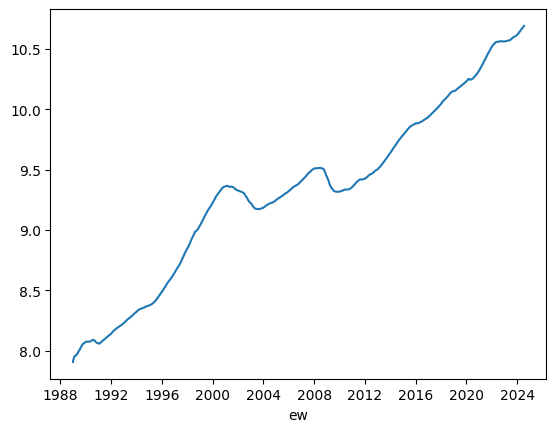

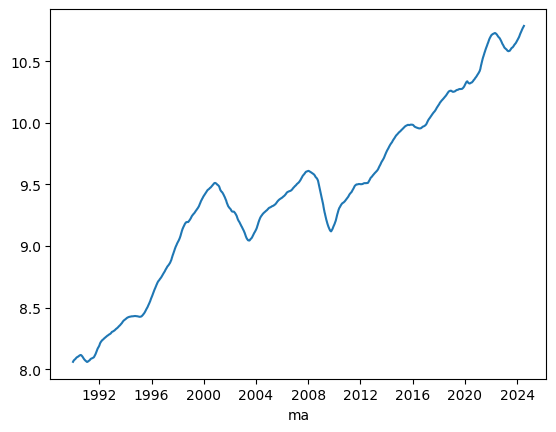

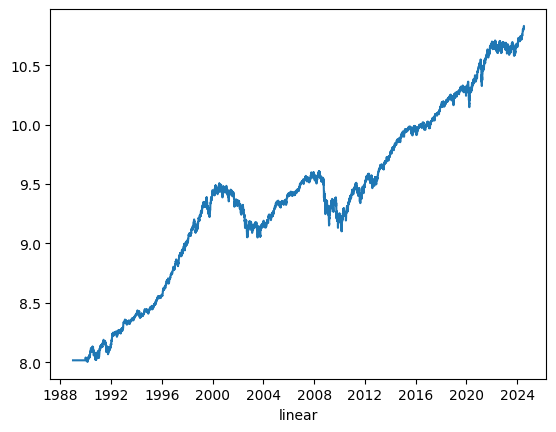

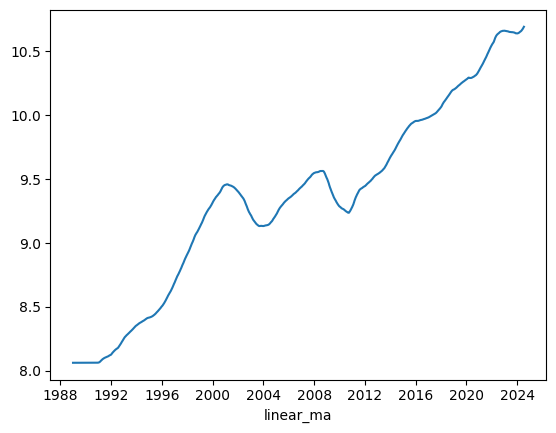

In [10]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [11]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [12]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [13]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [14]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [15]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [16]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(8.75788085278612,
 {'time_param': 41,
  'method': 'ma',
  't': 0.8978987497948937,
  'k': 7.025511016123814,
  'as_q': True,
  'transform_f': 'bounded_curve'})

Do nothing res: 6.762930056020962
Round 1: 8.7148416717892
New best: 8.7148416717892
{'time_param': 41, 'method': 'ma', 't': 0.8978987497948937, 'k': 7.025511016123814, 'as_q': True, 'transform_f': 'bounded_curve'}


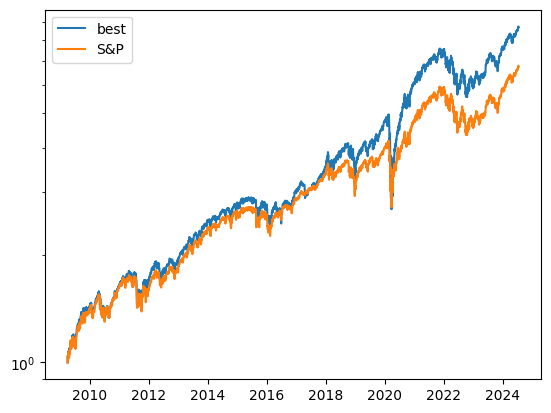

Round 2: 1.684328811507225
Round 3: 1.0485735035884574
Round 4: 1.129629554935863
Round 5: 3.674274546858215
Round 6: 2.5848688577881984
Round 7: 4.037704189484171
Round 8: 2.9845113452976246
Round 9: 3.9056349389029235
Round 10: 5.914522272379226
Round 11: 1.0004528729349589
Round 12: 2.951547558131681
Round 13: 3.0477924329877792
Round 14: 1.57978177658587
Round 15: 2.51587601461882
Round 16: 3.5274873118036
Round 17: 7.626912680047725
Round 18: 2.1579377888871294
Round 19: 7.88796703154698
Round 20: 3.160020197289332
Round 21: 1.9921861994514614
Round 22: 1.098899066949746
Round 23: 2.8850691619241946
Round 24: 2.670962924848575
Round 25: 2.8689804019379084
Round 26: 2.804851577574893
Round 27: 1.2999102077494864
Round 28: 2.663898545432108
Round 29: 7.209500971310367
Round 30: 3.479033165905467
Round 31: 5.426001635857642
Round 32: 2.499495361459876
Round 33: 7.056274390122111
Round 34: 1.1752242156236443
Round 35: 7.489905140654871
Round 36: 2.4603609832494793
Round 37: 1.71251370

In [17]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 6.762930056020962
Round 1: 7.687401398995895
Round 2: 6.112553019813847
Round 3: 8.058630767432469
Round 4: 7.968470786531384
Round 5: 7.9308675982489465
Round 6: 8.02831681007242
Round 7: 8.094382831471265
Round 8: 7.209160291363634
Round 9: 7.628894150907437
Round 10: 8.027384923951509
Round 11: 7.973542490576545
Round 12: 8.029295358720674
Round 13: 7.912427194988332
Round 14: 6.81744870040238
Round 15: 8.028870849937988
Round 16: 8.174062030591935
Round 17: 8.122013125775247
Round 18: 8.045768775079912
Round 19: 8.71218687887111
Round 20: 8.02375336790452
Round 21: 8.022866594261961
Round 22: 7.000984332516836
Round 23: 7.966972340093115
Round 24: 8.037378937142915
Round 25: 7.674908220091847

Factor: 1.03125
Do nothing res: 6.762930056020962
Round 1: 8.746647001172413
New best: 8.746647001172413
{'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}


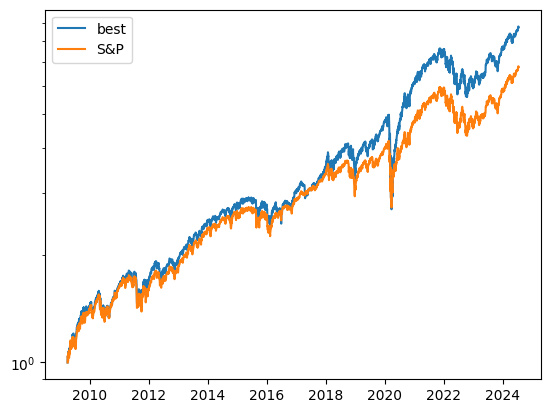

Round 2: 8.060906672246123
Round 3: 8.058477246886909
Round 4: 7.068556438127784
Round 5: 8.048048746567936
Round 6: 8.86522016266103
New best: 8.86522016266103
{'time_param': 37, 'method': 'ma', 't': 0.9823921944328939, 'k': 7.094213201833634, 'as_q': True, 'transform_f': 'bounded_curve'}


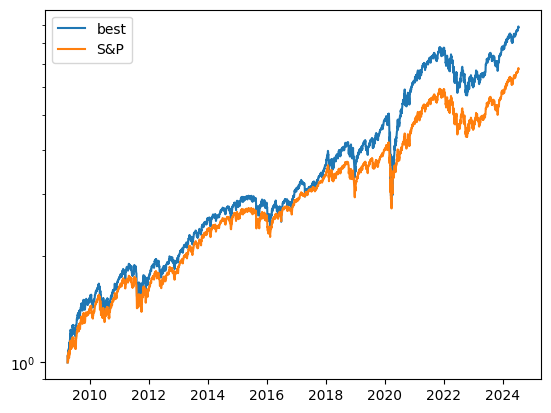

Round 7: 7.817493860234211
Round 8: 7.128134390764873
Round 9: 8.060593982327559
Round 10: 8.062142894475043
Round 11: 7.169850428874135
Round 12: 3.5648690514086345
Round 13: 7.095859241062063
Round 14: 7.9754439355896425
Round 15: 7.974634965815016
Round 16: 7.9752924673703225
Round 17: 6.832515011597692
Round 18: 7.9473657827524065
Round 19: 7.968366641467302
Round 20: 8.516420362441137
Round 21: 8.920961191038495
New best: 8.920961191038495
{'time_param': 36, 'method': 'ma', 't': 0.9757111043245056, 'k': 7.209565503453488, 'as_q': True, 'transform_f': 'bounded_curve'}


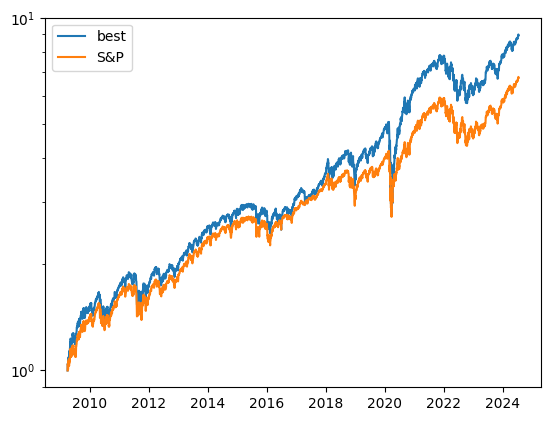

Round 22: 7.907495995309156
Round 23: 8.845847572882416
Round 24: 7.974298207187898
Round 25: 6.185069693291876

Factor: 1.015625
Do nothing res: 6.762930056020962
Round 1: 7.971438262148013
Round 2: 7.969548137593528
Round 3: 7.969857540666771
Round 4: 7.971060133826689
Round 5: 7.971686602165437
Round 6: 4.940283253545104
Round 7: 8.419138508709857
Round 8: 7.310200275871761
Round 9: 7.52314772991355
Round 10: 7.970570869019445
Round 11: 7.973064632097774
Round 12: 7.500479244286771
Round 13: 7.971456445590401
Round 14: 7.972793627984486
Round 15: 7.973603476687367
Round 16: 7.973458961425988
Round 17: 7.972664314086236
Round 18: 8.396371423461886
Round 19: 6.105201742736073
Round 20: 7.974174244748233
Round 21: 6.621989681247991
Round 22: 7.972682703170611
Round 23: 7.972273015553223
Round 24: 8.283399171049624
Round 25: 4.469230648024999

Factor: 1.0078125
Do nothing res: 6.762930056020962
Round 1: 7.971016625482118
Round 2: 8.865128222663763
Round 3: 7.97177684674989
Round 4: 7.13

In [18]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [ ]:
stop

In [48]:
# Force set:
best_out = 8.746647001172413
params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [49]:
final_out = simulate(df, params_out)

In [50]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9999997345931394

In [51]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.7480624508592609

In [52]:
params_out

{'time_param': 39,
 'method': 'ma',
 't': 0.9119734669470952,
 'k': 6.934678320149607,
 'as_q': True,
 'transform_f': 'bounded_curve'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:24: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + x**(np.log(2) / np.log(t)) - 1) ** k


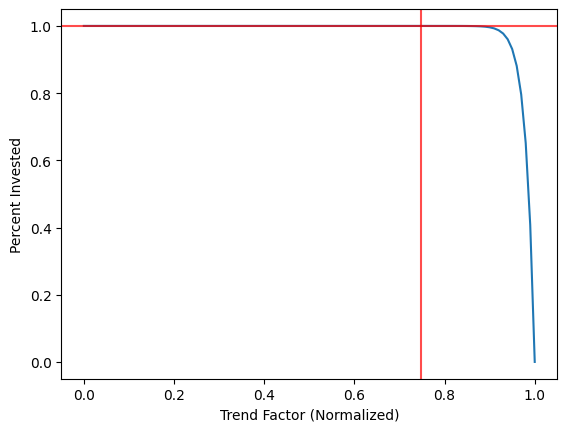

In [53]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

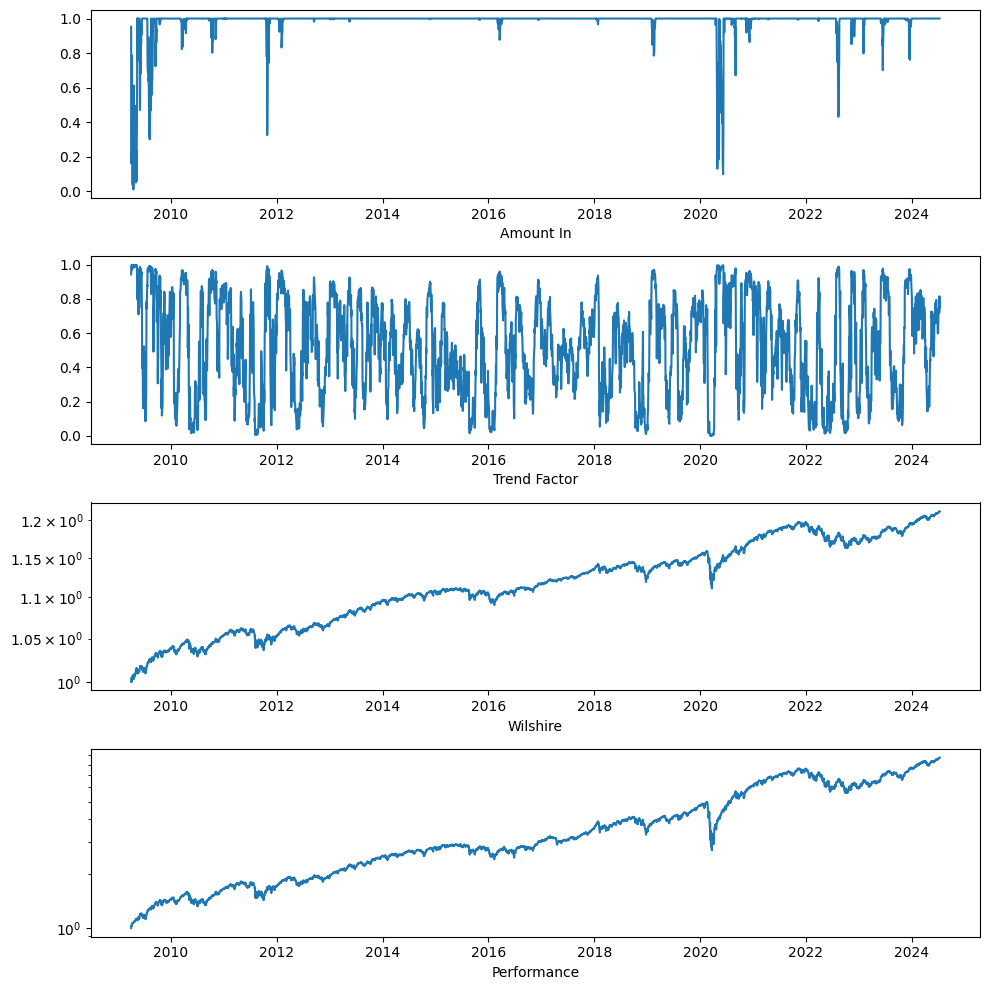

In [54]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('Wilshire')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [55]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Wilshire')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

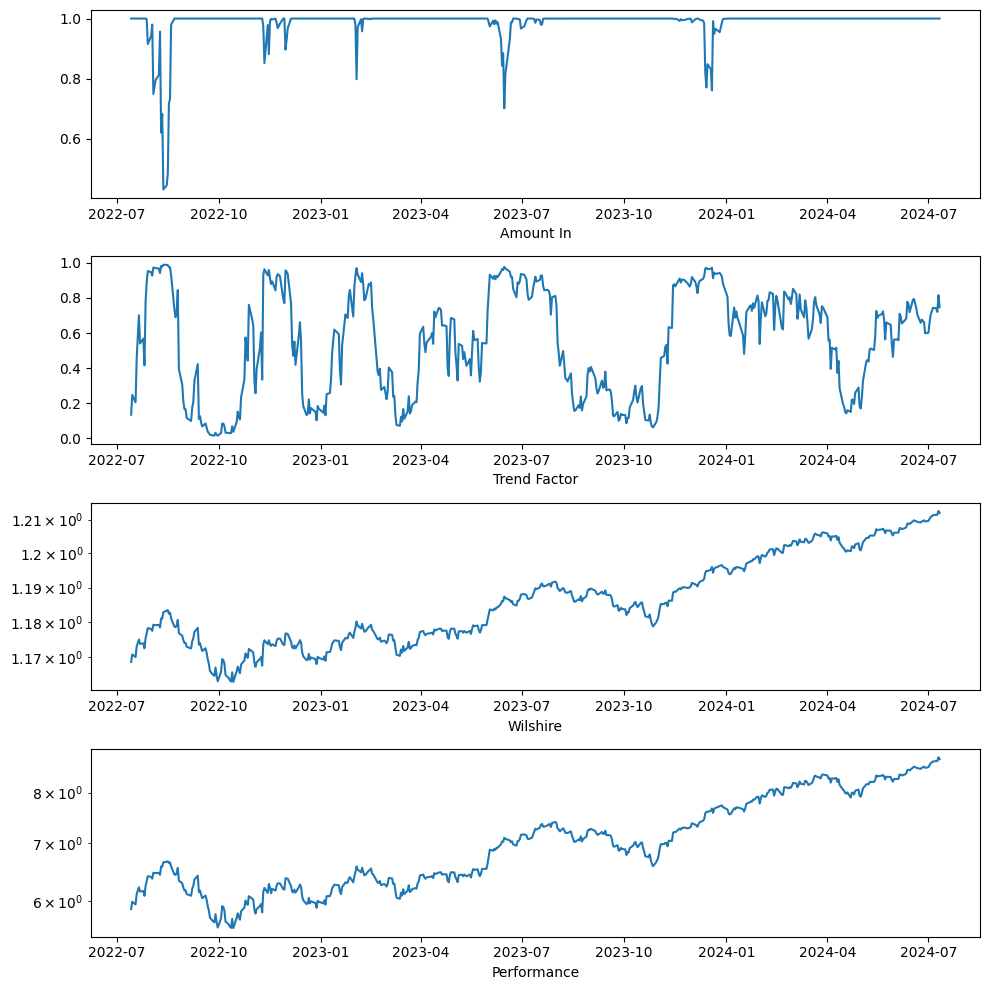

In [56]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('Wilshire')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [57]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(8.746647001172413,
 {'time_param': 39,
  'method': 'ma',
  't': 0.9119734669470952,
  'k': 6.934678320149607,
  'as_q': True,
  'transform_f': 'bounded_curve'})

In [58]:
round(final_out['amt_in'][-1], 4)

1.0

In [59]:
# amts (sp, nas, wil)
amts = np.array([106, 976, 8.75**2])
amts = amts / amts.sum()
amts

array([0.09149269, 0.84242326, 0.06608405])

In [60]:
# SPX, NAS, WIL
fracs = np.array([0.9707, 0.8248, 1])
amts * fracs

array([0.08881195, 0.69483071, 0.06608405])

In [63]:
# SPY, FNCMX, WINDX
current = np.array([17917, 139638, 13464])
cash = 30764
val = current.sum() + cash
target = (val * amts * fracs).round()
target

array([ 17921., 140205.,  13335.])

In [64]:
target - current

array([   4.,  567., -129.])